# JAM JENERATION

Starter code taken from this blog post on [jazz improvisation](https://www.hackerearth.com/blog/machine-learning/jazz-music-using-deep-learning/) with [Github repo](https://github.com/shubham3121/music-generation-using-rnn)

In [84]:
import sys
import re
import os
from collections import Counter

import numpy as np 
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from keras.utils import np_utils

from glob import glob
import IPython
import pickle

import music21

import play # requires pygame installation

In [34]:
from music21 import converter, instrument, note, chord, stream

In [35]:
# Any directory with .mid files in here is acceptable. We have 3 in Jazz and 26 in Beethoven.

songs = glob('Beethoven/*.mid')
print("Number of songs: {}".format(len(songs)))
print(songs[:5])

Number of songs: 26
['Beethoven/waldstein_1.mid', 'Beethoven/beethoven_opus90_2.mid', 'Beethoven/waldstein_2.mid', 'Beethoven/beethoven_opus90_1.mid', 'Beethoven/waldstein_3.mid']


# Baseline: Logistic Regression

In this super simple baseline, we ignore chords and pretend that all songs are just sequences of individual notes. Given a window of previous notes, we attempt to predict the next one.

There are three rough steps to data preprocessing:
1. Featurizing
2. Vectorizing
3. Extracting sequences from list

### Featurizing Methods

For each song, we convert it to a list of dictionary representation, where each dictionary represents the feature extraction for a given note/chord. This is the "featurizer" method. For every featurizer method, we also need an inverse method to go from feature dictionary to music21 stream.

Simple encoding:

it might look like:

[{"G5": 1},  {"C3": 1, "E3: 1}, . . .]

`featurize_song` goes from MIDI file to list of feature dictionaries. `songify_features` does the reverse and goes to a music21 stream. These methods can be customized for new encodings of our songs.

In [75]:
def featurize_song_simple(song_file):
    """
    Simple featurizer, featurizing each note/chord as just a one-note dictionary
    For chords in our piece, featurize the note of our top note.
    i.e. [{F#5: 1}, {C#7: 1}, {C5: 1}, etc.]
    
    Parameters:
    song_file: path to MIDI file of given song
    
    Returns list of featurized notes.
    """
    features_list = []
    midi = converter.parse(song_file)

    # Given a single stream, partition into a part for each unique instrument
    try:
        parts = instrument.partitionByInstrument(midi)
    except:
        pass
    
    notes_to_parse = []
    if parts: # if parts has instrument parts 
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        feature_dict = {}
        if isinstance(element, note.Note):
            # Featurize the pitch of notes
            feature_dict[str(element.pitch)] = 1
        elif(isinstance(element, chord.Chord)):
            # Featurize the first pitch of chords
            feature_dict[str(element.pitches[0])] = 1
        if feature_dict:
            # Only add entries with actual features
            features_list.append(feature_dict)

    print("Feautrized song {}".format(song_file))
    return features_list

In [80]:
def songify_features_simple(features_list):
    """
    Given a list representing a song's feature dictionaries, returns a music21 stream
    representing that song.
    Simple featurizer: for chords in our piece, featurize the note of our top note.
    i.e. [{F#5: 1}, {C#7: 1}, {C5: 1}, etc.]
    
    Parameters:
    features_list: list as described above
    
    Returns: music21 stream object
    """
    s = stream.Stream()
    for feat_dict in features_list:
        n = list(feat_dict.keys())[0]
        s.append(note.Note(n))
    return s

Feautrized song Jazz/CameronLeeSimpson-.mid
[{'A3': 1}, {'B-3': 1}, {'D5': 1}, {'D4': 1}, {'F3': 1}, {'G5': 1}, {'F3': 1}, {'B-2': 1}, {'D5': 1}, {'F3': 1}]


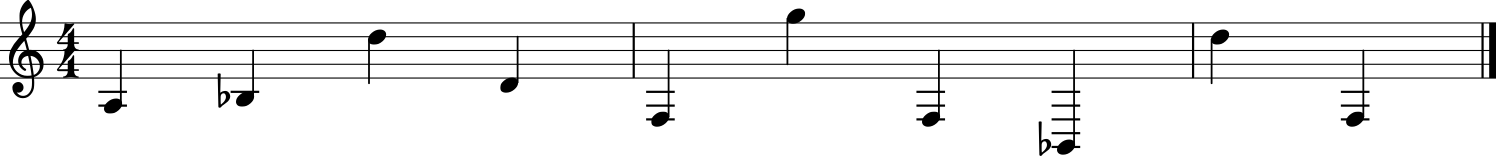

In [114]:
# Test our featurizing and reverse-featurizing methods
sample_midi_path = "Jazz/CameronLeeSimpson-.mid"
sample_features_list = featurize_song_simple(sample_midi_path)
print(sample_features_list[10:20])
sample_stream = songify_features_simple(sample_features_list[10:20])
sample_stream.show()

### Vectorize All Songs

In which we take all songs in a given directory path, featurize all of them, then convert all feature dictionaries to vector representations using sklearn's DictVectorizer

In [101]:
def vectorize_songs(featurizer, dir_path):
    """
    Takes in a directory path containing some MIDI folders.
    Featurizes all MIDI files in that path, vectorizes all, returns huge list of vectors.
    
    Parameters:
    featurizer: a featurizer as described in the earlier section
    
    Returns:
    encodings: a numpy array of encoded vectors
    vectorizer: the sklearn DictVectorizer() object used to generate encodings. Can be used to decode.
    """
    songs = glob(os.path.join(dir_path, '*.mid'))
    features_list = []
    for song in songs:
        song_feats = featurizer(song)
        features_list += song_feats
    
    # TODO: Screen out UNK tokens if not frequent enough
    # TODO: Could make vectorizer sparse for performance. Currently not sparse for interpretability.
    vectorizer = DictVectorizer(sparse=False) 
    vectorizer.fit(features_list)
    print("Number of distinct notes: {}".format(len(vectorizer.feature_names_)))
    return vectorizer.transform(features_list), vectorizer

In [102]:
sample_jazz_vecs, sample_jazz_vectorizer = vectorize_songs(featurize_song_simple, "Jazz")
sample_jazz_vecs[0]

Feautrized song Jazz/CameronLeeSimpson-.mid
Feautrized song Jazz/AndreandSchwandt-aLittleDream.mid
Feautrized song Jazz/Berckman-Berckman.mid
Number of distinct notes: 50


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Prepare Sequences

Given a sequence of vector representations, breaks it into training sets and labels.

For example if `sequence_length` is 10, then it will take a sequeence of vector representations, and break into all possible sequences of 11 notes. Each first ten notes will be a training input, each 11th note will be the label.

In [109]:
def prepare_vector_sequences(vector_list, sequence_length):
    """
    Prepares list vectors for one-hot encoding input into classifer
    
    Parameters:
    vector_list: list of vectors; each vector represents a note/chord; sequence of vectors represents songs
    sequence_length: how many previous words to consider in sliding window
    
    Returns:
    X: a list of training examples, where each training example are concatenations of encoded vectors
        Each training input in X is thus (sequence_length * n_vocab) in length
    y: a list of vector representations. Each vector corresponds to the next vector in corresponding sequence from X
    """

    # Slide a window over our notes, adding sequences to dataset
    X, y = [], []
    for i in range(0, len(vector_list) - sequence_length):
        sequence_in = vector_list[i : i + sequence_length]
        sequence_in = np.concatenate(sequence_in, axis=None)
        label_out = vector_list[i + sequence_length]
        X.append(sequence_in)
        y.append(label_out)
    
    return X, y

In [115]:
# Test our vector sequences and labels to make sure they align with earlier jazz test
sample_jazz_X, sample_jazz_y = prepare_vector_sequences(sample_jazz_vecs, 10)
print("Number of training examples: {}".format(len(sample_jazz_X)))
sample_jazz_outputs = sample_jazz_vectorizer.inverse_transform(sample_jazz_y[:5])
print("First 5 jazz outputs: {}".format(sample_jazz_outputs))

Number of training examples: 722
First 5 jazz outputs: [{'A3': 1.0}, {'B-3': 1.0}, {'D5': 1.0}, {'D4': 1.0}, {'F3': 1.0}]


## Dataset Extraction Full Method

In which we tie together featurizing, vectorizing, and sequence extraction into one unified method. This should be highly customizable so we can plug in any featurizer and sequence_length in to generate our datasets.

In [ ]:
def extract_dataset(dir_path, featurizer, sequence_length):
    """
    The core data extraction method.

    Parameters:
    dir_path: path to directory of songs to extract data from
    featurizer: featurizing method to extract feature dictionaries from notes
        (e.g. featurize_song_simple)
    sequence_length: how many songs to store in each window
    
    Returns:
    X: input dataset of vector-encoded sequences
    y: output labels, also vector-encoded
    vectorizer: an sklearn DictVectorizer, which can decode vector representations to features
    """

Note that the following train-test split procedure could be somewhat flawed. We don't split on unseen (unheard) songs, so a melody that appears multiple times in one song could be picked up later on in the model.

In [10]:
simple_X_train, simple_X_test, simple_y_train, simple_y_test = train_test_split(simple_X, simple_y, test_size=0.15)
simple_y_train[:5]
print("Train set size: {}".format(len(simple_y_train)))
print("Test set size: {}".format(len(simple_y_test)))

Train set size: 63404
Test set size: 11189


### Train Simple Logistic Regression Multi-Class Classification Model

In this simpler problem, we assume that each sequence of notes has one and only one note succeeding it. This makes it a multi-class classification problem.

Later we'll have to expand it to multi-label problem for chords.

In [11]:
logreg = LogisticRegression()
logreg.fit(simple_X_train, simple_y_train)

/Users/etang/dev/jam-jeneration/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/etang/dev/jam-jeneration/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
simple_preds_test = logreg.predict(simple_X_test)
sklearn.metrics.accuracy_score(simple_preds_test, simple_y_test)

0.28027527035481276

### Composing!

In which we attempt to use our previous work to generate a melody and play it.

Work in progress. We display and show notes, but haven't yet done the heavy lifting of actually composing.

In [13]:
def stream_for_note_list(note_list):
    """
    Returns a music21 stream given a list of notes ['A5', 'C#4', 'E#3']
    This should allow us to show and play a 
    """
    s = stream.Stream()
    for n in note_list:
        s.append(note.Note(n))
    return s

In [29]:
def play_stream(our_stream, save_path=None):
    """
    Displays notes, plays audio, saves MIDI file for a given music21 stream object
    """
    # We use music21 to read in notes, play.py to play music
    # Unfortunately, music21 midi player doesn't work with Jupyter so we use play.py
    our_stream.show()
    save_path = save_path or 'output/temp_stream.midi'
    our_stream.write('midi', save_path)
    play.play_midi(save_path)

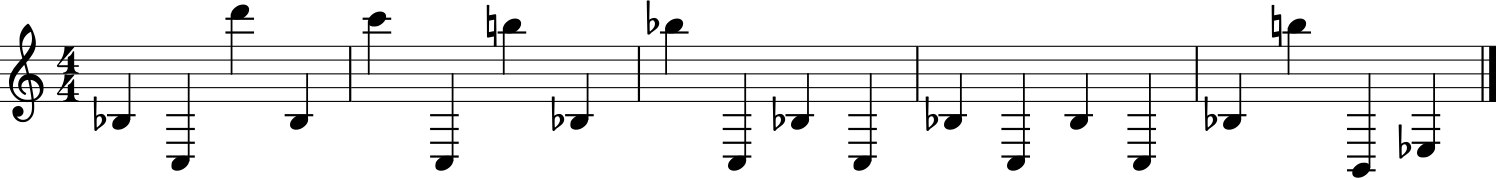

Music file output/temp_stream.midi loaded!


In [32]:
simple_stream = stream_for_note_list(simple_notes[400:420])
play_stream(simple_stream)

# LSTM Models

(Work in Progress)

## Extracting Chords and Notes

In [53]:
def get_notes():
    notes = []
    for file in songs:
        # converting .mid file to stream object
        midi = converter.parse(file)
        notes_to_parse = []
        try:
            # Given a single stream, partition into a part for each unique instrument
            parts = instrument.partitionByInstrument(midi)
        except:
            pass
        if parts: # if parts has instrument parts 
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes
    
        for element in notes_to_parse: 
            if isinstance(element, note.Note):
                # if element is a note, extract pitch
                notes.append(str(element.pitch))
            elif(isinstance(element, chord.Chord)):
                # if element is a chord, append the normal form of the 
                # chord (a list of integers) to the list of notes. 
                notes.append('.'.join(str(n) for n in element.normalOrder))
    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    return notes

In [54]:
get_notes()[145:155]

['G3', 'F2', 'F3', 'E2', '10.2.4', 'E3', '7.10.0', '0', '10.0.4', '7.10.0']

## Preparing Sequence Vectors

In [6]:
def prepare_sequences(notes, n_vocab): 
    sequence_length = 100

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i: i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    
    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

## LSTM Model

In [35]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
def create_network(network_in, n_vocab): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(128, input_shape=(100,1), return_sequences=True)) # network_in.shape[1:]
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
#     print(network_in.shape[1:])

    return model

In [27]:
from keras.callbacks import ModelCheckpoint
def train(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'weights.best.music3.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=[checkpoint])

In [40]:
def train_network():
    """
    Get notes
    Generates input and output sequences
    Creates a model 
    Trains the model for the given epochs
    """
    
    epochs = 50
    
    notes = get_notes()
    print('Notes processed')
    
    n_vocab = len(set(notes))
    print('Vocab generated')
    
    network_in, network_out = prepare_sequences(notes, n_vocab)
    print('Input and Output processed')
    
    model = create_network(network_in, n_vocab)
    print('Model created')
#     return model
    print('Training in progress')
    train(model, network_in, network_out, epochs)
    print('Training completed')
    
    return model
    

In [41]:
### Train the model 
model = train_network()

Notes processed
Vocab generated
Input and Output processed
Model created
Training in progress
Epoch 1/50
632/632 [==============================] - 7s 11ms/step - loss: 4.0883
Epoch 2/50
632/632 [==============================] - 5s 8ms/step - loss: 3.6452
Epoch 3/50
632/632 [==============================] - 5s 7ms/step - loss: 3.4801
Epoch 4/50
632/632 [==============================] - 5s 7ms/step - loss: 3.3889
Epoch 5/50
632/632 [==============================] - 5s 7ms/step - loss: 3.2978
Epoch 6/50
632/632 [==============================] - 5s 7ms/step - loss: 3.2238
Epoch 7/50
632/632 [==============================] - 5s 8ms/step - loss: 3.1480
Epoch 8/50
632/632 [==============================] - 5s 8ms/step - loss: 3.0585
Epoch 9/50
632/632 [==============================] - 5s 8ms/step - loss: 2.9736
Epoch 10/50
632/632 [==============================] - 5s 8ms/step - loss: 2.9379
Epoch 11/50
632/632 [==============================] - 5s 7ms/step - loss: 2.8721
Epoch 12/50


## Composition

In which we take a model and actually generate music!

In [42]:
def generate(model=None):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))
    
    print('Initiating music generation process.......')
    
    network_input = get_inputSequences(notes, pitchnames, n_vocab)
    
#             reshaped_input = np.reshape(pattern, (1, len(pattern), 1))
#         prediction_input = prediction_input / float(n_vocab)
        
    if not model:
        model = create_network(network_input, n_vocab)
        print('Loading Model weights.....')
        model.load_weights('weights.best.music3.hdf5')
    else:
        print('Using given model')
    
    print('Model Loaded')
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [43]:
def get_inputSequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    return (network_input)

In [44]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # Pick a random integer
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    
    # pick a random sequence from the input as a starting point for the prediction
    pattern = network_input[start]
    prediction_output = []
    
    print('Generating notes........')

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)
        
        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern.append(index)
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    print('Notes Generated...')
    return prediction_output

In [45]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    
    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='test_output4.mid')

In [46]:
#### Generate a new jazz music 
generate(model)

Initiating music generation process.......
Using given model
Model Loaded
Generating notes........
Notes Generated...
Saving Output file as midi....


In [18]:
### Play the Jazz music
play.play_midi('test_output4.mid')

NameError: name 'play' is not defined